# Convolutional autoencoders

In this script we write a CNN autoencoder and apply it to the task of image desnoising.

<center><a href="https://en.wikipedia.org/wiki/Total_variation_denoising">
    <img src="https://upload.wikimedia.org/wikipedia/commons/e/e8/ROF_Denoising_Example.png"></a></center>


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [ ]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

# Plot function
def myplot(x):
    plt.figure()
    plt.imshow(x.detach().squeeze().numpy(), cmap='gray')
    plt.show()
    return

## Transposed convolution

As seen in the previous lab, convolution usually reduces the size of the image (except if we compensate using padding). However, in some applications (e.g., image synthesis from low-dimension features) it is usefull to increase it. That's notably needed for autoencoders, since after projecting the data into a compact latent representation, we need to expand this representation back into the image space.

This is exactly what [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) does. Simply put, a transposed convolution adds some zeros inside the input image (and on the edge) to artificially increase the size.

Convolution             |  Transposed convolution
:-------------------------:|:-------------------------:
![](https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif)  |  ![](https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif)


On the left, we use convolution with a kernel size of 3 and stride of 2. On the right, we then use a transposed convolution with the same parameters, and its effect is to procude an image with the same size as the original.

torch.Size([1, 1, 343, 550])


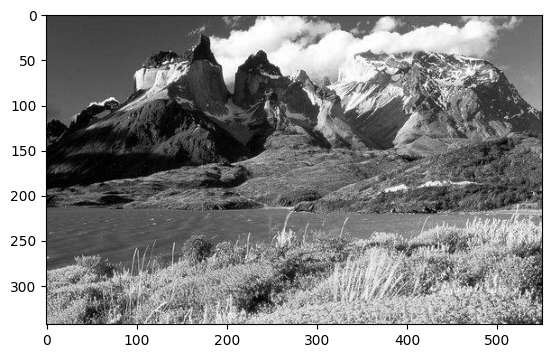

In [ ]:
# Load the provided example image, and convert it in black and white
image_t = torchvision.io.read_image('/content/tdp.jpeg', mode=torchvision.io.ImageReadMode.RGB)
image_t = torchvision.transforms.functional.rgb_to_grayscale(image_t)

# Convert as a float tensor, normalize it so the values range in [0, 1], and expand to a batch
image_t = image_t.float()
image_t /= image_t.max()
image_t = image_t.unsqueeze(0)

# Print the shape and plot it
print(image_t.shape)
myplot(image_t)

Original image:  torch.Size([1, 1, 343, 550])
Output of the convolution :  torch.Size([1, 1, 86, 137])


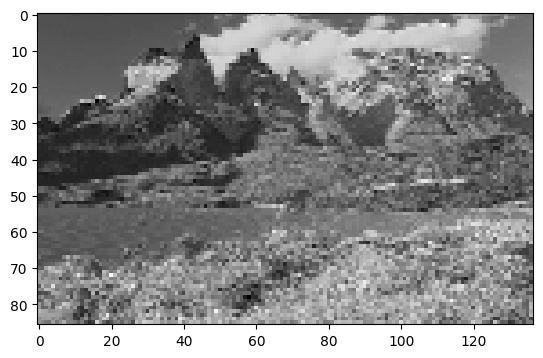

In [ ]:
num_channels_in = 1
num_channels_out = 1

# First, let us apply a convolution with a kernel size of (3, 6) and a stride of 4.
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
output = my_conv(image_t)
print('Original image: ', image_t.shape)
print('Output of the convolution : ', output.shape)

# Display the output after convolution
myplot(output)

After applying transposed convolution :  torch.Size([1, 1, 343, 550])


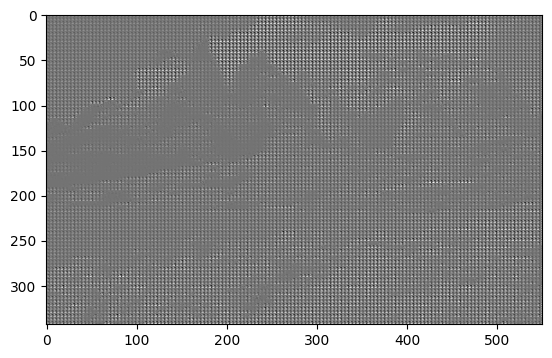

In [ ]:
# Now we reproduce an image with the same size as the original input
my_convt = nn.ConvTranspose2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4)
image_convt = my_convt(output)
print('After applying transposed convolution : ', image_convt.shape)

# Display the output after transposed convolution
myplot(image_convt)

As you can see, transposed convolution does not invert convolution (it's not "deconvolution"): it only guarantees that the size will be equal to that of the image before convolution (but not its pixel values).

## Dataset

In [ ]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 52179203.78it/s]


Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1778347.46it/s]

Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12667418.98it/s]


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8388608.00it/s]

Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



## CNN autoencoder

As seen in lab 4, autoencoders are networks that project the input data into a low-dimension space, and then expand this compact representation back into the input space. In CNN autoencoders, the encoder uses convolutions to reduce the image size, while the decoder uses transposed convolutions to expand it. We propose the following architecture:

- The encoder consists of two layers, with a convolution function, a RELU and a max pooling. The convolution functions have a kernel size of 3 and a padding of 1. They use 16 and 4 output channels, respectively. The max pooling functions use a kernel size of 2.

- The decoder consists of two layers, with a transposed convolution and an activation function (RELU for the first layer, Sigmoid for the second layer). The transposed convolution functions have a kernel size of 2 and a stride of 2. They use 16 and 1 output channels, respectively.

In [ ]:
# TO DO: write the CNN autoencoder module ('__init__' and 'forward' methods)
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)

        return out

class CNNDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU())

        self.cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid())

    def forward(self, x):

        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)

        return out

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Create instances of MLPClassif_Decoder and MLPClassif_Encoder
        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()

    def forward(self, x):
        y = self.encoder(x)
        out = self.decoder(y)
        return out

In [ ]:
# Instantiate the CNN autoencoder, initialize it, and print the number of parameters
model_cnn_ae = CNNAutoencoder()
model_cnn_ae.apply(init_params)
print('Total number of parameters:', sum(p.numel() for p in model_cnn_ae.parameters()))

Total number of parameters: 1077


In [ ]:
# Before training, make sure that the output of the autoencoder has the same shape as its input.
# If that's not the case, there's something to debug somewhere.
image_batch_example = next(iter(train_dataloader))[0]
out = model_cnn_ae(image_batch_example)
print(image_batch_example.shape)
print(out.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


In [ ]:
# TO DO: write the autoencoder training function with validation (also write the evaluation function)
# # It's similar to the MLP autoencoder (lab 4.2), but images don't need to be vectorized

def train_cnn_ae(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    #make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    #set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    #define the optimizer (ADAM)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    #initialize a list to save the training loss over epochs
    loss_all_epochs = []
    #training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        #iterate over batches (here we don't need labels
        for batch, (images, _) in enumerate(train_dataloader):
            # forward pass
            images_predicted = model_tr(images)
            loss = loss_fn(images_predicted, images)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_current_epoch += loss.item()
        loss_current_epoch /= len(train_dataloader)
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
    return model_tr, loss_all_epochs

<span style="color:red">**Exercice 3**</span> Using the training parameters below, train the model and plot the training and validation losses on the same plot.

In [ ]:
# Training parameters
num_epochs = 50
loss_fn = nn.MSELoss()
learning_rate = 0.001

In [ ]:
def train_cnn_ae(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    #make copy of the model
    model_copy = copy.deepcopy(model)
    #define the optimizer
    optimizer = torch.optim.Adam(model_copy.parameters(), lr=learning_rate) #Fixed: Changed learning to learning_rate
    #initliaizng list to save all the epochs
    loss_all_epochs=[]
    #training the loop
    for epoch in range(num_epochs):
        loss_current_epoch=0
        for batch_idx, (data, target) in enumerate(train_dataloader):
            #forward pass
            out = model_copy(data) #added forward pass to calculate the output of the model.
            loss = loss_fn(out, data) #changed target to data as autoencoder tries to reconstruct the input itself.
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_current_epoch += loss.item()

        loss_current_epoch /= len(train_dataloader) #Fixed: Indentation corrected to be inside the epoch loop.
        # At the end of each epoch, record the loss over all batches
        loss_all_epochs.append(loss_current_epoch)

        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

    return model_copy, loss_all_epochs #Changed model_tr to model_copy as this is the one trained.

In [ ]:
#finding epochs
loss_fn = nn.MSELoss()
num_epochs =  50
learning_rate = 0.001
model_cnn_ae_tr, loss_all_epochs = train_cnn_ae(model_cnn_ae, train_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 1.1858
Epoch [2/50], Training loss: 0.8496
Epoch [3/50], Training loss: 0.6186
Epoch [4/50], Training loss: 0.5828
Epoch [5/50], Training loss: 0.5641
Epoch [6/50], Training loss: 0.5474
Epoch [7/50], Training loss: 0.5351
Epoch [8/50], Training loss: 0.5281
Epoch [9/50], Training loss: 0.5234
Epoch [10/50], Training loss: 0.5197
Epoch [11/50], Training loss: 0.5162
Epoch [12/50], Training loss: 0.5136
Epoch [13/50], Training loss: 0.5112
Epoch [14/50], Training loss: 0.5093
Epoch [15/50], Training loss: 0.5077
Epoch [16/50], Training loss: 0.5064
Epoch [17/50], Training loss: 0.5052
Epoch [18/50], Training loss: 0.5043
Epoch [19/50], Training loss: 0.5035
Epoch [20/50], Training loss: 0.5027
Epoch [21/50], Training loss: 0.5019
Epoch [22/50], Training loss: 0.5014
Epoch [23/50], Training loss: 0.5008
Epoch [24/50], Training loss: 0.5003
Epoch [25/50], Training loss: 0.4998
Epoch [26/50], Training loss: 0.4995
Epoch [27/50], Training loss: 0.4992
Epoch [28/

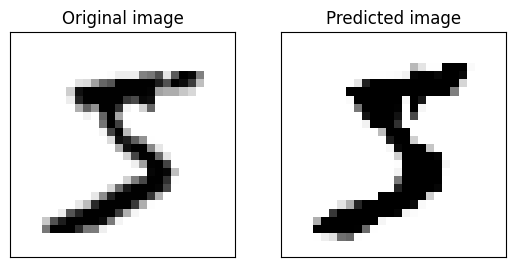

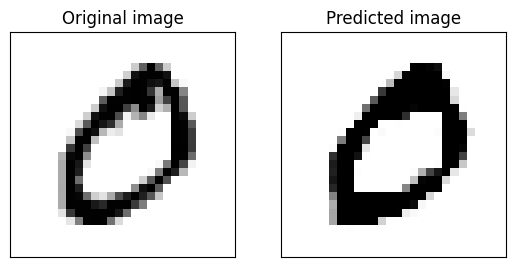

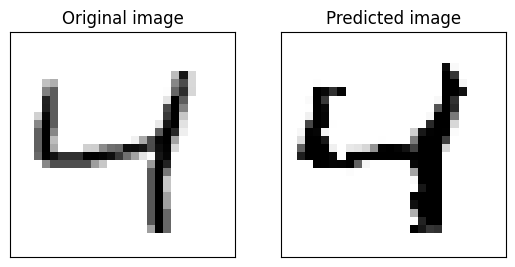

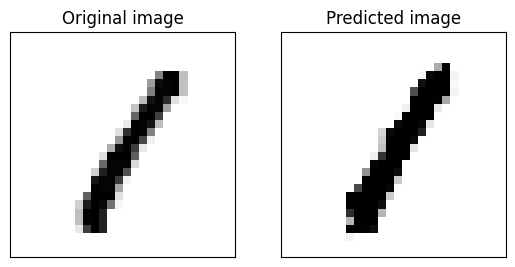

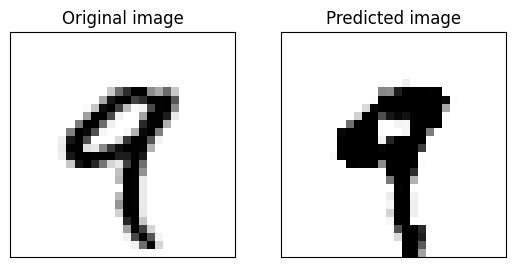

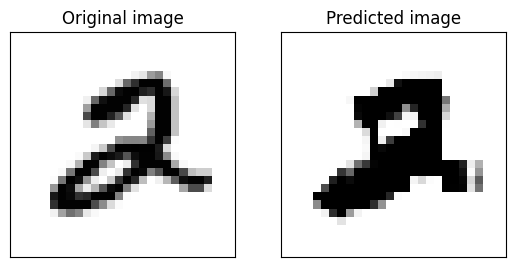

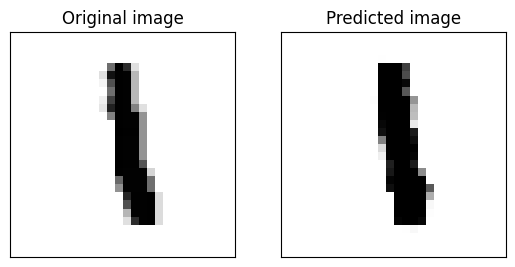

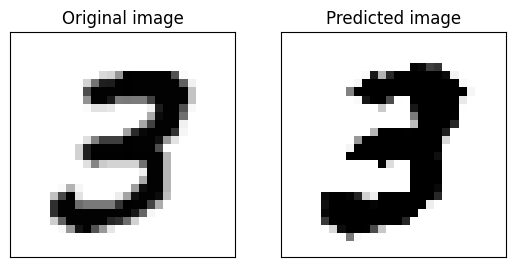

In [ ]:
# Vizualization

# Get an example batch from the test set
test_batch_example = next(iter(test_dataloader))[0]

# Pass it to the autoencoder
with torch.no_grad():
    test_batch_example_pred = model_cnn_ae_tr(test_batch_example)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(test_batch_example_pred[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

## Denoising autoencoder

We now consider an application of autoencoders, which is image denoising. We use the same CNN autoencoder model as above, but the thing that changes is the data on which it is trained. Indeed, the denoising autoencoder takes as inputs the noisy images, and outputs clean (denoised) imaged. However, we don't need to create a new dataset with noisy images: we simply need to add noise to the images during training before passing them to the model.

<center><a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SxwRp9i23OM0Up4sEze1QQ@2x.png" width="550"></a></center>


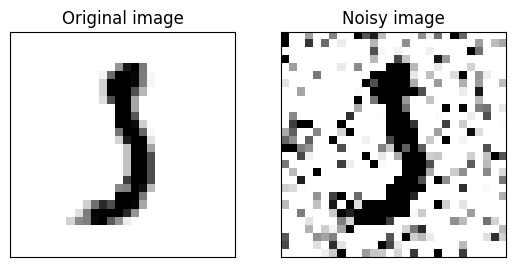

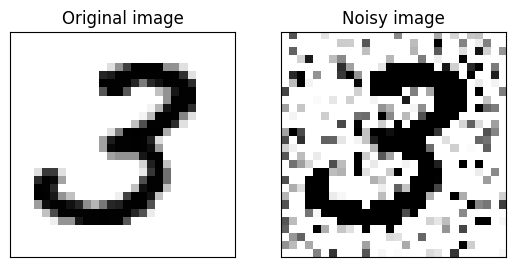

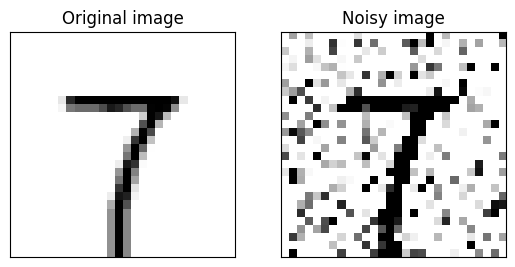

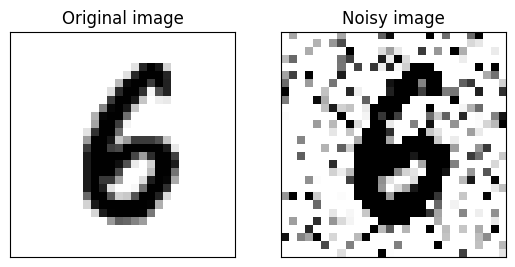

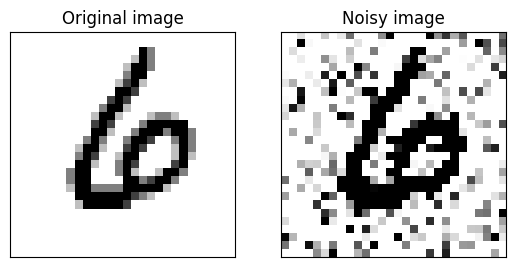

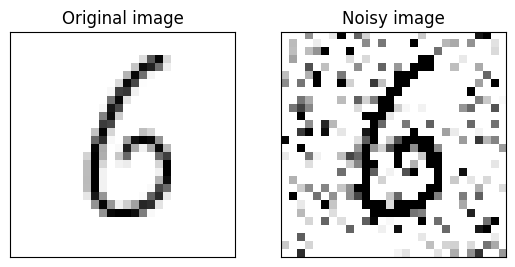

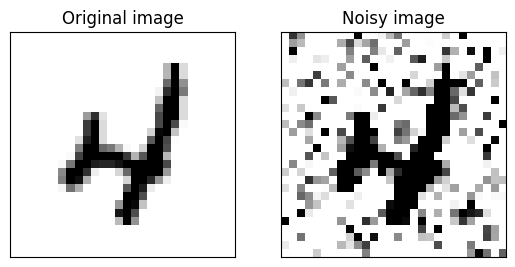

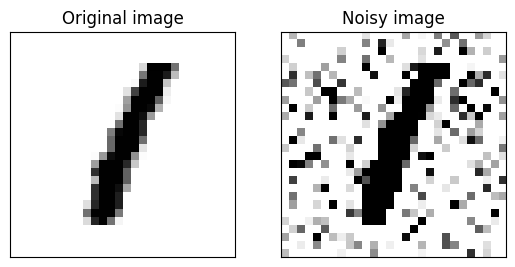

In [ ]:
# First, here is a function that adds some noise to an input image batch
def add_noise(inputs,noise_factor=0.8):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

# Add noise to the image_batch_example
noisy_images_batch = add_noise(image_batch_example)

# Plot the original and noisy images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.show()

The training function is the same as before, except that we need to add the noise to the images before passing them to the model. Then, we compute the loss between the original images (clean) and the output of the model (denoised).

In [ ]:
# TO DO: write the training function (with validation) for the denoising autoencoder
def train_cnn_ae_denoising(model, train_dataloader, num_epochs, loss_fn, learning_rate, noise_factor=0.5, verbose=True):
    #make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    #set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()
    #define the optimizer (ADAM)
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    #initialize a list to save the training loss over epochs
    loss_all_epochs = []
    #training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        #iterate over batches (here we don't need labels
        for batch, (images, _) in enumerate(train_dataloader):
            # Add noise to the images
            noisy_images = add_noise(images, noise_factor)
            # forward pass
            images_predicted = model_tr(noisy_images)
            loss = loss_fn(images_predicted, images)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_current_epoch += loss.item()
        loss_current_epoch /= len(train_dataloader)
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
    return model_tr, loss_all_epochs

<span style="color:red">**Exercice 4**</span> Instanciate a CNN autoencoder and initialize its parameters. Using the same training parameters as above, train the model for the denoising task. After training, plot the training and validation losses over epochs (on the same plot).

In [ ]:
#instantiate the CNN autoencoder, initialize it, and print the number of parameters
model_cnn_ae_denoising = CNNAutoencoder()
model_cnn_ae_denoising.apply(init_params)

#training parameters
num_epochs = 50
loss_fn = nn.MSELoss()
learning_rate = 0.001
noise_factor = 0.5

#train the model
model_cnn_ae_denoising_tr, loss_all_epochs_denoising = train_cnn_ae_denoising(model_cnn_ae_denoising, train_dataloader, num_epochs, loss_fn, learning_rate, noise_factor)

Epoch [1/50], Training loss: 1.2020
Epoch [2/50], Training loss: 1.0183
Epoch [3/50], Training loss: 0.7479
Epoch [4/50], Training loss: 0.6583
Epoch [5/50], Training loss: 0.6368
Epoch [6/50], Training loss: 0.6287
Epoch [7/50], Training loss: 0.6206
Epoch [8/50], Training loss: 0.6111
Epoch [9/50], Training loss: 0.5981
Epoch [10/50], Training loss: 0.5867
Epoch [11/50], Training loss: 0.5780
Epoch [12/50], Training loss: 0.5674
Epoch [13/50], Training loss: 0.5544
Epoch [14/50], Training loss: 0.5449
Epoch [15/50], Training loss: 0.5391
Epoch [16/50], Training loss: 0.5340
Epoch [17/50], Training loss: 0.5295
Epoch [18/50], Training loss: 0.5254
Epoch [19/50], Training loss: 0.5218
Epoch [20/50], Training loss: 0.5200
Epoch [21/50], Training loss: 0.5179
Epoch [22/50], Training loss: 0.5156
Epoch [23/50], Training loss: 0.5143
Epoch [24/50], Training loss: 0.5135
Epoch [25/50], Training loss: 0.5122
Epoch [26/50], Training loss: 0.5112
Epoch [27/50], Training loss: 0.5108
Epoch [28/

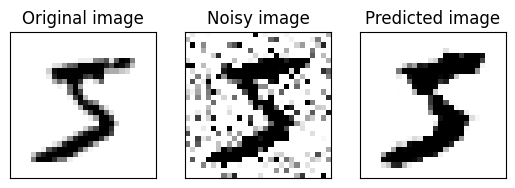

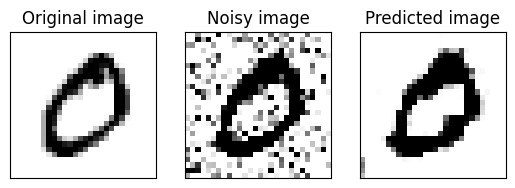

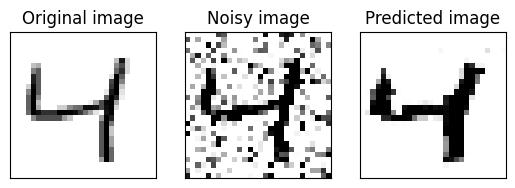

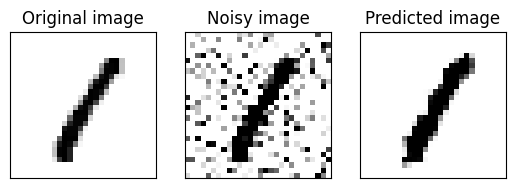

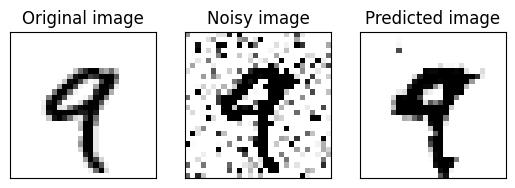

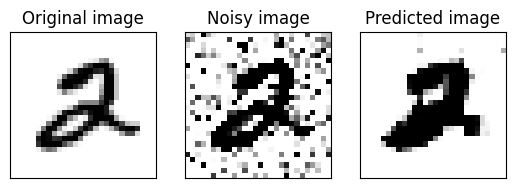

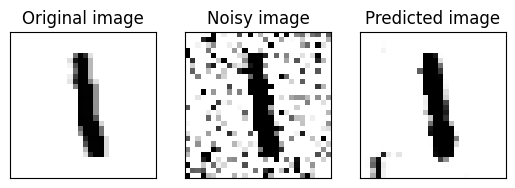

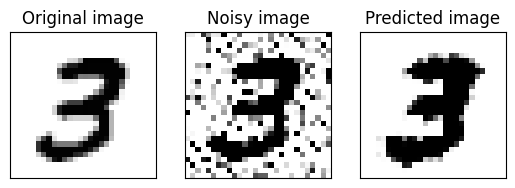

In [ ]:
# Vizualization

# Add noise to the test batch
test_batch_example_noisy = add_noise(test_batch_example)

# Pass the noisy images to the autoencoder
# Using model_cnn_ae_denoising_tr instead of model_cnn_den_ae_tr
with torch.no_grad():
    test_batch_example_den = model_cnn_ae_denoising_tr(test_batch_example_noisy)

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(test_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(test_batch_example_noisy[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.subplot(1, 3, 3)
    plt.imshow(test_batch_example_den[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()